In [20]:
report_date = '2021-08-23 00:00:00'

In [21]:
# !pip install pandas
# !pip install pymssql
# !pip install sklearn
#!pip install pendulum

In [22]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
import datetime
import pendulum
import pytz

In [23]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            # autocommit=True
        )

In [24]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [25]:
def spent_time_vs_duration():
    print('spent time vs audio record duration')    
    df.plot(x="duration", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [26]:
def spent_time_vs_date():
    print('spent time on timeline')
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()
    df.plot(x="time_int", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [27]:
def coef():
    x_train = np.array(df.duration).reshape(-1, 1)
    y_train = np.array(df.time).reshape(-1, 1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_train)
    plt.scatter(x_train, y_train,  color='gray')
    plt.plot(x_train, y_pred, color='red', linewidth=2)
    plt.show()
    print('linear regression coef', model.coef_)
    return model.coef_[0][0]

In [28]:
def performance():
    
   
    print('performance: seconds of recognized audio per 10 min')
    counter = [0 for _ in range(int(df.time_int.max()/600))]
    
    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    plt.plot([x for x in range(len(counter))], counter, 'o', color='red', linewidth=2)
    plt.show()
    print([int(c) for c in counter])

In [29]:
def perf_cores():

    print('performance by cores count:')
    
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()

    counter = [[] for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append([])
        counter[cell].append(row.cores)

    cores = np.nan_to_num( [np.mean(c) for c in counter] )

    counter = [0 for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    
    pc = pd.DataFrame([cores, counter]).T
    pc.columns = ['cores', 'time']
    pc = pd.DataFrame(pc.groupby('cores').mean())
    pc.reset_index(level=0, inplace=True)
    
    plt.plot(pc.cores, pc.time, 'o', color='red', linewidth=2)
    plt.show()

In [30]:
def cores_to_performance_calculated(report_date):
    
    print('cores count performance calculated:')
    
    query = "select cores, time, duration"
    query += " from perf_log "
    query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
    df = read_sql()
    df['td'] = df.time/df.duration
    df['perf'] = df.time/df.duration/df.cores
    df.drop(['duration','time'], axis=1, inplace=True)

    #meantd = df.groupby(df.cores).mean()
    #meantd.reset_index(level=0, inplace=True)
    #plt.plot(meantd.cores, meantd.td, 'o')

    #mediantd = df.groupby(df.cores).median()
    #mediantd.reset_index(level=0, inplace=True)
    #plt.plot(mediantd.cores, mediantd.td, 'o')

    mediantd = df.groupby(df.cores).median()
    mediantd.reset_index(level=0, inplace=True)
    plt.plot(mediantd.cores, mediantd.perf, 'o')

In [31]:
def reco_prognose():
    query = "select sum(duration) from queue"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    queued_duration = float(df_queued.iloc[0])
    time_prognose = queued_duration * performance_coef
    print('recognize time prognose:', int(time_prognose), 'sec')
    print('or', int(time_prognose/60), 'min')
    print('or', int(time_prognose/60/60), 'h')
    print('or', int(time_prognose/60/60/24), 'd')

In [32]:
def colorator(source_id):
    return 'red' if source_id == 1 else 'green'

In [33]:
def earliest_records():
    print('earliest records')
    query = "select source_id, min(record_date) from queue group by source_id order by source_id;"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    print(df_queued)

In [34]:
#query = "select event_date, cpu, time, duration from perf_log where step = 1 and duration<400 and time > 1000;"
#query = "select cpu, count(cpu) as cnt, sum(time) as time_sum from perf_log where step = 2 and time > 1000 group by cpu order by cpu;"
#query = "select event_date, time as time_sum from perf_log where step = 2 and cpu = 3 order by event_date;"

In [35]:
def plot_cpu_usage():
    df.groupby(['cpu']).sum().plot(y = ['time'], kind="bar")

In [36]:
def queue_time_vs_date():
    queue['color'] = queue['source_id'].apply(colorator)
    
    q_a = queue[queue.source_id == 1]
    q_b = queue[queue.source_id == 2]
    
    ratio = max(queue.queued_seconds_from_now) / max(queue.recorded_seconds_from_now) * 10
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    
    ax.scatter(
        q_a.queued_seconds_from_now, 
        q_a.recorded_seconds_from_now, 
        color=q_a['color'],
        label="call",
         marker = 'x'
    )
    ax.scatter(
        q_b.queued_seconds_from_now, 
        q_b.recorded_seconds_from_now, 
        color=q_b['color'],
        label="mrm",
        marker = '.'
    )
    currentdate = datetime.datetime.today()
    currentdate = currentdate.strftime('%Y.%m.%d %H:%M:%S')
    #datetime.datetime.strptime(df, f_0).strftime(f_1)
    ax.set_title('Очередь ' + currentdate, fontsize=18)

    # Set common labels
    ax.set_xlabel('Добавлено, сек. назад', fontsize=18)
    ax.set_ylabel('Записано, сек. назад', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.savefig('queue.png')

spent time vs audio record duration


/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


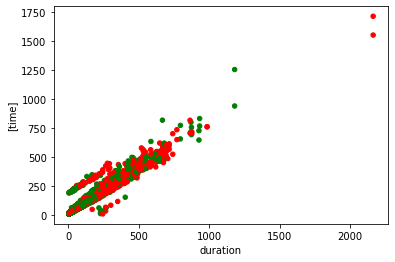

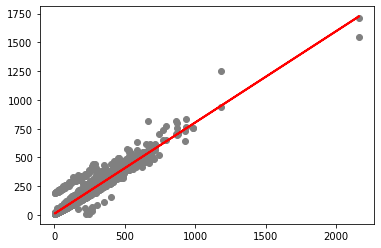

linear regression coef [[0.79431413]]
spent time on timeline


/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


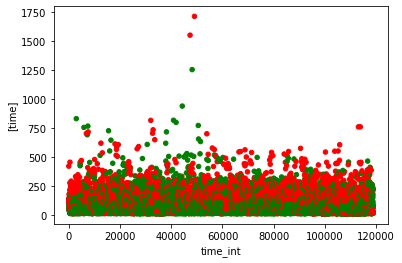

performance: seconds of recognized audio per 10 min


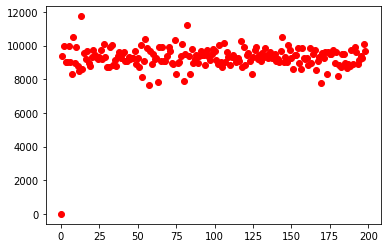

[0, 9369, 9992, 9028, 9014, 9948, 9015, 8284, 10501, 8946, 9900, 8811, 8501, 11743, 8593, 9577, 9184, 9652, 8939, 8779, 9339, 9765, 9435, 9293, 9193, 9304, 9720, 9198, 10093, 9350, 8749, 8747, 9930, 10035, 8844, 9129, 8797, 9408, 9647, 9244, 9524, 9639, 9066, 9056, 9297, 9174, 9260, 9260, 9689, 8919, 9235, 8711, 10048, 8124, 9086, 10396, 9856, 7682, 9696, 8901, 9503, 9194, 9276, 7809, 9894, 9084, 9919, 9092, 9073, 9371, 9922, 9696, 8946, 8906, 10338, 8333, 8995, 9007, 9363, 10076, 7880, 9507, 11200, 9379, 8288, 9815, 8943, 9197, 9413, 8949, 9358, 9694, 9414, 9416, 8841, 9742, 9400, 9165, 9515, 9806, 9668, 9137, 8919, 10045, 9019, 8732, 10142, 9045, 9618, 9348, 8858, 9310, 9446, 9272, 9014, 9240, 9089, 10296, 8741, 9925, 8862, 9463, 9551, 9058, 8295, 9315, 9713, 9905, 9232, 9451, 9088, 9539, 9319, 9871, 9455, 9263, 9604, 9279, 9347, 9509, 9069, 9214, 9035, 9703, 10509, 9023, 9293, 9035, 10055, 9749, 9250, 8638, 9446, 9446, 9867, 8952, 8604, 9851, 9239, 9189, 9260, 8838, 9832, 8973, 9474

/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


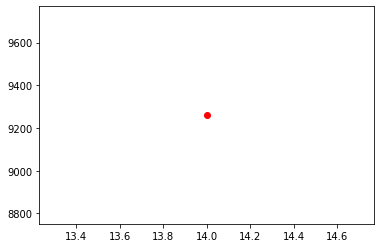

recognize time prognose: 637076 sec
or 10617 min
or 176 h
or 7 d
earliest records
   source_id                    
0          1 2021-04-13 18:29:45
1          2 2021-04-13 18:30:07


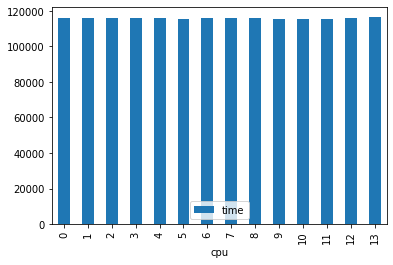

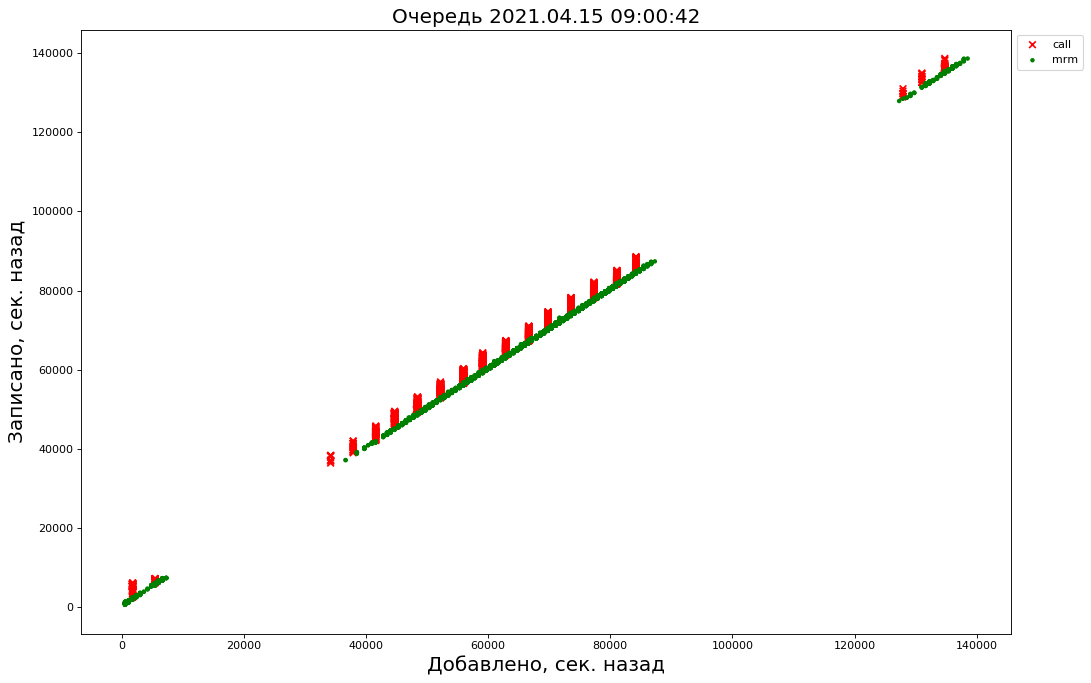

In [80]:
query = "select event_date, cpu, time, duration, source_id, cores"
query += " from perf_log "
#query += " where cores = 9 and step = 2 and event_date > '2021-03-12 15:27:00' and time > 5;"
query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
df = read_sql(query)
df['color'] = df['source_id'].apply(colorator)
spent_time_vs_duration()
performance_coef = coef()
#print('9 cores')
spent_time_vs_date()
performance()
perf_cores()
plot_cpu_usage()
reco_prognose()
earliest_records()

query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

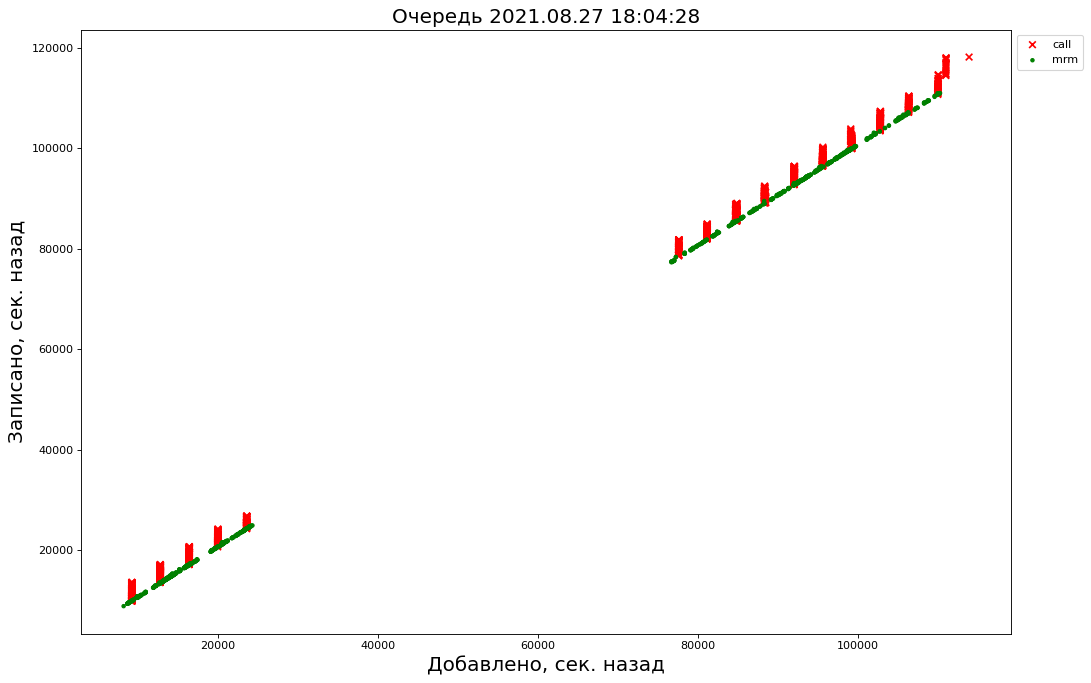

In [132]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

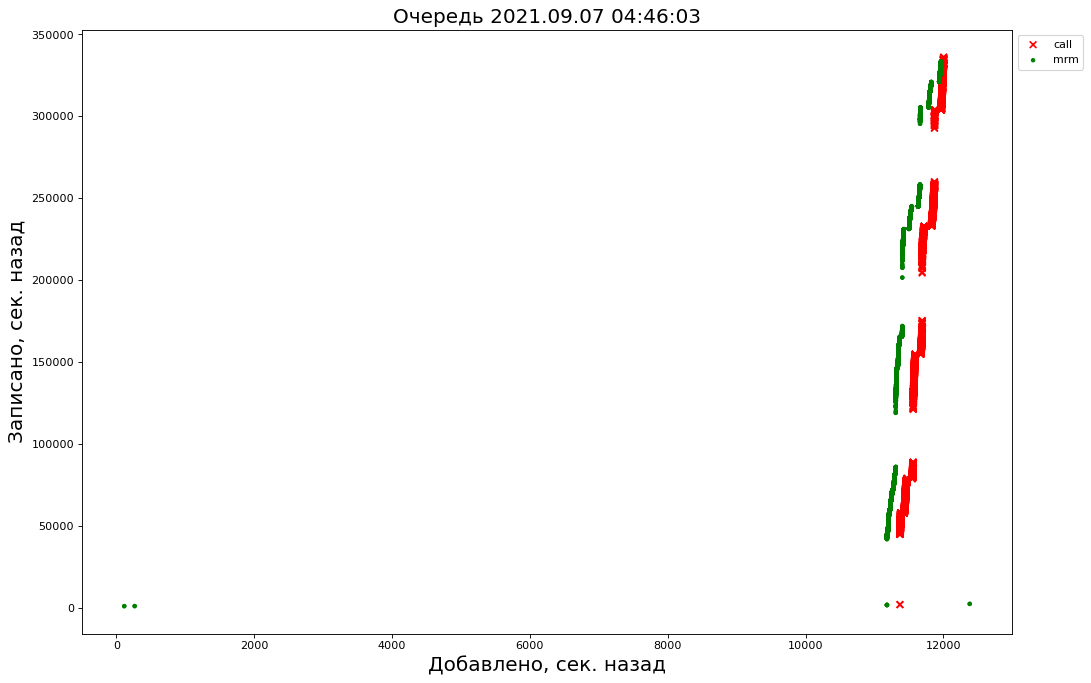

In [42]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [81]:
#cores_to_performance_calculated()

In [82]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='queue';"
queue = read_sql(query)
queue

,column_name
0,date
1,cpu_id
2,filepath
3,date_y
4,date_m
5,date_d
6,filename
7,duration
8,record_date
9,source_id


In [83]:
query = "SELECT version, record_date, filename FROM queue order by record_date;"
queue = read_sql(query)
queue

,version,record_date,filename
0,0,2021-04-13 18:29:45,in_79055029008_2021-04-13-18-29-45rxtx.wav
1,1,2021-04-13 18:30:07,a2021-04-13t18:30:07b_c9099827168d_e8999820191...
2,0,2021-04-13 18:30:37,a2021-04-13t18:30:37b_c9111328570d_es_g1618327...
3,1,2021-04-13 18:32:36,a2021-04-13t18:32:36b_c1467d_e89041277107f_g16...
4,1,2021-04-13 18:33:41,a2021-04-13t18:33:41b_c9689595864d_e8915479879...
...,...,...,...
10882,1,2021-04-15 08:49:56,a2021-04-15t08:49:56b_c9031798162d_e8925000570...
10883,1,2021-04-15 08:50:02,a2021-04-15t08:50:02b_c9168145353d_e8926209048...
10884,1,2021-04-15 08:50:02,a2021-04-15t08:50:02b_c9168145353d_e8926209048...
10885,1,2021-04-15 08:50:22,a2021-04-15t08:50:22b_c9162577685d_e8916379835...


In [ ]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

In [4]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by count(linkedid) desc;"
queue = read_sql(query)
queue

NameError: name 'read_sql' is not defined

In [41]:
# queue by cpu
print(datetime.datetime.now().astimezone(pytz.timezone('Europe/Moscow')))
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

2021-09-07 07:44:53.352415+03:00


,cpu_id,
0,0,1727
1,1,1729
2,2,1735
3,3,1728
4,4,1735
5,5,1724
6,6,1736
7,7,1732
8,8,1733


In [18]:
# queue by cpu
print(datetime.datetime.now().astimezone(pytz.timezone('Europe/Moscow')))
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

2021-09-07 07:16:43.889474+03:00


,cpu_id,
0,9,1610
1,10,1611
2,11,1610
3,12,1591
4,13,1597
5,14,1589
6,15,1581
7,16,1624
8,17,1583
9,18,1593


### scratch

In [38]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='perf_log';"
df = read_sql(query)
df

,column_name
0,event_date
1,step
2,cpu
3,duration
4,linkedid
5,source_id
6,cores
7,time
8,file_name


In [78]:
start_date = '2021-09-06 16:10:00'
end_date = '2022-08-25 00:00:00'

query = "select file_name, cpu, time, duration"
query += " from perf_log "
query += " where step = 2 and event_date > '"+start_date+"' and time > 5"
query += " and event_date < '"+end_date+"';"
df = read_sql(query)
df['td'] = df.duration/df.time

In [79]:
len(df)

1429

<AxesSubplot:title={'center':'Транскрибация аудиофайлов'}, xlabel='Ядро', ylabel='Количество файлов'>

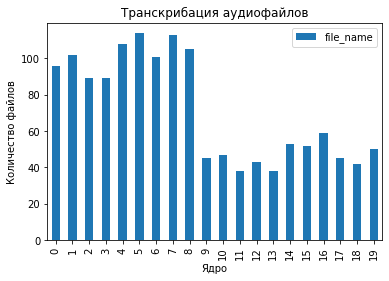

In [80]:
#df.groupby(['cpu']).count().plot(y = ['file_name'], kind="bar")
df.groupby('cpu').count().plot(
    y = ['file_name'], 
    kind="bar", 
    xlabel='Ядро', 
    ylabel='Количество файлов', 
    title='Транскрибация аудиофайлов'
)

In [81]:
df.drop(['file_name', 'time', 'duration'], axis=1, inplace = True)

<AxesSubplot:title={'center':'Медианная производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

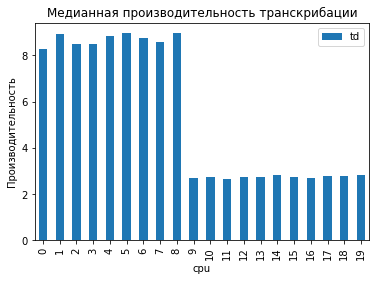

In [82]:
df.groupby('cpu').median().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Медианная производительность транскрибации'
)

<AxesSubplot:title={'center':'Средняя производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

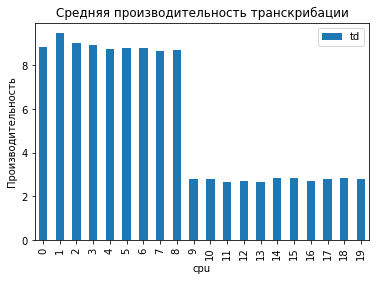

In [83]:
df.groupby('cpu').mean().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Средняя производительность транскрибации'
)

### check transcribations

In [21]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [46]:
#report_date = '2021-08-23 14:06:17'
#report_date = '2021-08-24 11:25:00'
report_date = '2021-09-07 07:40:00'
query = "select top 10 cpu_id, linkedid, start, side, text"
#query = "select file_name, cpu"
query += " from transcribations "
query += " where transcribation_date > '"+report_date+"' "
query += " and duration > 5 and source_id = 2"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by cpu_id, linkedid, start;"
df = read_sql(query)
df

,cpu_id,linkedid,start,side,text
0,0,1630654997.539729,13.615830,True,добро пожаловать
1,0,1630655541.540519,6.450000,False,давай
2,0,1630655541.540519,8.580000,False,хорошо
3,0,1630655541.540519,9.960000,False,мама
4,0,1630655541.540519,14.460000,False,вам пора покупать продукты кто-то пытается
5,0,1630655541.540519,19.410000,False,отключение включено
6,0,1630655541.540519,21.090000,False,папа папа папа папа папа мама и папа
7,0,1630655541.540519,27.103896,False,папа мама папа баба
8,0,1630655903.540952,10.410000,True,игра
9,0,1630655903.540952,15.870000,True,а я стороны


In [61]:
df

,source_id,cpu_id,linkedid,start,side,text
0,1,0,1629709604.2051480,0.0,False,
1,1,0,1629709604.2051480,0.0,True,


In [44]:
for idx, row in df.iterrows():
    print(row.text)

добро пожаловать
давай
хорошо
мама
вам пора покупать продукты кто-то пытается
отключение включено
папа папа папа папа папа мама и папа
папа мама папа баба
игра
а я стороны


# DROP WRONG

In [78]:
start_date = '2021-08-23 15:10:00'
end_date = '2021-08-24 15:32:00'
query = "select top 100 source_id, cpu_id, linkedid, start, side, text"
#query = "select file_name, cpu"
query += " from transcribations "
query += " where cpu_id < 2"
query += " and source_id = 1"
query += " and transcribation_date > '"+start_date+"' "
query += " and transcribation_date < '"+end_date+"' "
query += " and duration > 5"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by linkedid, start;"
df = read_sql(query)
df

,source_id,cpu_id,linkedid,start,side,text
0,1,1,1629357991.1954401,0.061233,True,и
1,1,1,1629357991.1954401,4.260000,True,здравствуйте единая служба сервиса оператора юля
2,1,1,1629357991.1954401,13.890000,True,стиральная машина какая как называется
3,1,1,1629357991.1954401,18.660000,True,мож черте города находятся территориально
4,1,1,1629357991.1954401,24.450000,True,вон в городе ли в области находитесь
...,...,...,...,...,...,...
95,1,1,1629358552.1954886,91.650000,False,покажи истории может быть ты принесёшь номер н...
96,1,1,1629358552.1954886,100.320000,False,серия дот
97,1,1,1629358552.1954886,102.030000,True,все всё этого достаточно больше ничего не надо...
98,1,1,1629358552.1954886,104.100000,False,позже эти у тебя


### queue

In [18]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [ ]:
### server debug

In [33]:
batch_size = 100
cpu_id = 11
past_in_minutes = pendulum.now().add(minutes=-6).strftime('%Y-%m-%d %H:%M:%S')
sql_query = "select top "+str(batch_size)+" filepath, filename, duration, source_id, "
sql_query += "record_date, src, dst, linkedid, file_size, date from queue "
sql_query += "where cpu_id='" + str(cpu_id) + "' "
sql_query += "and ( (source_id = '2' and record_date < '" + past_in_minutes + "') or not source_id = '2' ) "
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
sql_query += "order by record_date, filename;"

queue = read_sql(sql_query)
queue

,filepath,filename,duration,source_id,record_date,src,dst,linkedid,file_size,date
0,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_4996120291_2021-08-27-08-43-32rxtx.wav,68.16,1,2021-08-27 08:43:32,4996120291,5042,1630043011.2156553,2181164,2021-08-27 09:31:06
1,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_8127770011_2021-08-27-08-44-12rxtx.wav,9.24,1,2021-08-27 08:44:12,8127770011,5010,1630043050.2156576,295724,2021-08-27 09:31:06
2,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_8127770011_2021-08-27-08-44-44rxtx.wav,16.76,1,2021-08-27 08:44:44,8127770011,5042,1630043082.2156606,536364,2021-08-27 09:31:07
3,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_79063695054_2021-08-27-08-45-21rxtx.wav,7.94,1,2021-08-27 08:45:21,79063695054,None,1630043119.2156628,254124,2021-08-27 09:31:07
4,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_78314222525_2021-08-27-08-45-48rxtx.wav,49.96,1,2021-08-27 08:45:48,78314222525,5021,1630043147.2156666,1598764,2021-08-27 09:31:08
...,...,...,...,...,...,...,...,...,...,...
60,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:07b_c9254214853d_e9857969400...,52.28,2,2021-08-27 09:31:07,9254214853,9857969400,1630045865.284160,836524,2021-08-27 09:42:26
61,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:19b_c9811890939d_e9213497425...,34.60,2,2021-08-27 09:31:19,9811890939,9213497425,1630045877.284171,553644,2021-08-27 09:42:26
62,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:19b_c9811890939d_e9213497425...,34.80,2,2021-08-27 09:31:19,9811890939,9213497425,1630045877.284171,556844,2021-08-27 09:42:26
63,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:36b_c9957826046d_e9067370483...,36.98,2,2021-08-27 09:31:36,9957826046,9067370483,1630045894.284186,591724,2021-08-27 09:42:26
